In [1]:
import scipy.stats as sps
import math
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.optimize import minimize_scalar
from collections import defaultdict
from collections.abc import Callable, Iterable
from functools import lru_cache
from itertools import combinations
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

import warnings
warnings.filterwarnings("ignore")

In [2]:
SAMPLE_SIZES = [10, 20, 50, 100, 200]
SIMPLE_METHODS = ["z-score", "DBSCAN", "IQR"]
METHODS = ["z-score", "DBSCAN", "IQR", "at least 2"]
M = 1000
FRR = 0.05
N = 500
DBSCAN_ITERS = 100
MODELLING_SIZE = 200

In [3]:
DISTROS = {"Norm":    sps.norm(    loc=0,             scale=1),
           "Uniform": sps.uniform( loc=-math.sqrt(3), scale=2 * math.sqrt(3)),
           "Exp":     sps.expon(   loc=-1,            scale=1)}

Можно удостовериться, что все эти случайные величины действительно стандартные (с нулевым матожиданием и единичной дисперсией): 

In [4]:
for d in DISTROS:
    print(f"{d}: E[r] = {DISTROS[d].stats('m')}, Var[r] = {DISTROS[d].stats('v'):.1f}")

Norm: E[r] = 0.0, Var[r] = 1.0
Uniform: E[r] = 0.0, Var[r] = 1.0
Exp: E[r] = 0.0, Var[r] = 1.0


Реализуем определение выбросов обычным z_score. Для этого для каждого распределения нужно найти критическое его значение $z_{\text{крит}}$ методом моделирования

In [5]:
def z(sample: Iterable[float],
      el: float | Callable[[Iterable], float] | None = None
      ) -> float | list[float]:

        x_mean, s = np.mean(sample), np.std(sample)
        if el is not None:
            try:
                x = float(el)
            except:
                x = el(sample)
            return abs(x - x_mean) / s
        else:
            return [abs(x - x_mean) / s for x in sample]

In [6]:
@lru_cache
def get_z_crit(distribution: str, frr: float):
    z_distr = [z(DISTROS[distribution].rvs(MODELLING_SIZE)) for _ in range(N)]
    z_critical = np.quantile(z_distr, 1 - frr)
    return z_critical

def detect_outliers_z_score(sample, distribution, frr):
    z_critical = get_z_crit(distribution, frr)
    outliers = [x for x in sample if z(sample, x) > z_critical]
    return outliers

Чтобы получить $\text{FRR}$ таким, какой мы хотим, надо найти нужный эпсилон (максимальное расстояние между двумя точками, чтобы считать их соседями). Для этого будем генерировать $N$ выборок и считать для них реальный $\text{FRR}^*$. Тогда мы найдём наилучший эпсилон, минимизировав выражение по эпсилон
$$|\text{FRR}^* - FRR| = \left|\frac{\# \text{true inliers, classified as outliers}}{\# \text{true inliers}} - \text{FRR}\right|$$

In [7]:
@lru_cache
def get_DBSCAN_params(distribution, frr, n, min_samples=5):
    def objective(eps, distribution, frr, n, min_samples):
        db = DBSCAN(eps=eps, min_samples=min_samples)
        metric = 0
        for _ in range(DBSCAN_ITERS):
            sub_sample = np.array(DISTROS[distribution].rvs(n))
            sub_sample = sub_sample.reshape(-1, 1)
            db_labels = db.fit_predict(sub_sample)
            num_outliers = len(sub_sample[db_labels == -1])
            metric += abs((num_outliers / MODELLING_SIZE) - frr)
        return metric / DBSCAN_ITERS
    
    bounds = (0.01, 2)
    minimization_result: sps.optimize.OptimizeResult = minimize_scalar(fun=objective,
                                                                       args=(distribution, frr, n, min_samples),
                                                                       bounds=bounds)
    epsilon = minimization_result.x
    # print(minimization_result.message, '\nTarget FRR achieved with error ', minimization_result.fun)
    return epsilon

In [8]:
def detect_outliers_DBSCAN(sample, distribution, frr):
    eps = get_DBSCAN_params(distribution, frr, len(sample))
    db = DBSCAN(eps=eps)
    db_labels = db.fit_predict(np.array(sample).reshape(-1, 1))
    outliers = sample[db_labels == -1]
    return outliers

In [9]:
for d in DISTROS:
    for n in SAMPLE_SIZES:
        print(f"{d}, n={n}, epsilon = {get_DBSCAN_params(d, FRR, n)}")

Norm, n=10, epsilon = 0.04598439920683802
Norm, n=20, epsilon = 0.2746050367374318
Norm, n=50, epsilon = 0.20213020220084438
Norm, n=100, epsilon = 0.1680565935969816
Norm, n=200, epsilon = 0.13398873851061677
Uniform, n=10, epsilon = 0.1370055395612888
Uniform, n=20, epsilon = 0.30343383126896983
Uniform, n=50, epsilon = 1.9999960318087815
Uniform, n=100, epsilon = 1.9999960318087815
Uniform, n=200, epsilon = 1.9999960318087815
Exp, n=10, epsilon = 0.08703867004350929
Exp, n=20, epsilon = 0.17684379642611275
Exp, n=50, epsilon = 0.19033002929503126
Exp, n=100, epsilon = 0.17169246873577387
Exp, n=200, epsilon = 0.1925381653957841


In [11]:
@lru_cache
def quant(distribution: str, q: float) -> float:
    return DISTROS[distribution].ppf(q)

@lru_cache
def IQR_k(distribution, frr):
    match distribution:
        case 'Norm':
            return (quant(distribution, 1 - frr / 2) - quant(distribution, 0.75)) /  (quant(distribution, 0.75) - quant(distribution, 0.25))
        case 'Uniform':
            return (quant(distribution, 1 - frr / 2) - quant(distribution, 0.75)) /  (quant(distribution, 0.75) - quant(distribution, 0.25))
        case 'Exp':
            return (quant(distribution, 1 - frr) - quant(distribution, 0.75)) /  (quant(distribution, 0.75) - quant(distribution, 0.25))
        case _:
            return 1.5

def detect_outliers_IQR(sample, distribution, frr):
    x_25, x_75 = quant(distribution, 0.25), quant(distribution, 0.75)
    IQR = x_75 - x_25
    k = IQR_k(distribution, frr)
    left = x_25 - k * IQR
    right = x_75 + k * IQR
    outliers = [x for x in sample if not left <= x <= right]
    return outliers

Обёрточная функция над всеми методами для удобства. Метод 'at least 2' подразумевает использование всех трёх методов, при этом выбросами признаются те значения, которые были определены как выбросы хотя бы двумя методами.

In [12]:
def detect_outliers(sample: Iterable, distribution: str, frr: float, method: str) -> list[float]:
    match method:
        case 'z-score':
            return detect_outliers_z_score(sample, distribution, frr)
        case 'DBSCAN':
            return detect_outliers_DBSCAN(sample, distribution, frr)
        case 'IQR':
            return detect_outliers_IQR(sample, distribution, frr)
        case 'at least 2':
            outliers = {method: set(detect_outliers(sample, distribution, frr, method)) for method in SIMPLE_METHODS}
            res = set()
            for (method_1, method_2) in combinations(SIMPLE_METHODS, 2):
                res |= outliers[method_1] & outliers[method_2]
            return list(res)
        case _:
            return []

In [13]:
# method, distribution, n
results = {method: {distr: {} for distr in DISTROS} for method in METHODS}
for n_id, n in enumerate(SAMPLE_SIZES):
    print("Sample size", n)
    for distr_id, distr in enumerate(DISTROS):
        print("   ", distr)
        cur_res = defaultdict(int)
        for _ in trange(M):
            sample = DISTROS[distr].rvs(n)
            for method in METHODS:
                cur_res[method] += len(detect_outliers(sample, distr, FRR, method))
        for method in METHODS:
            results[method][distr][n] = cur_res[method] / (M * n)
    print('-' * 100)

Sample size 10
    Norm


100%|██████████| 1000/1000 [00:01<00:00, 534.56it/s]


    Uniform


100%|██████████| 1000/1000 [00:01<00:00, 540.13it/s]


    Exp


100%|██████████| 1000/1000 [00:01<00:00, 538.81it/s]


----------------------------------------------------------------------------------------------------
Sample size 20
    Norm


100%|██████████| 1000/1000 [00:02<00:00, 391.57it/s]


    Uniform


100%|██████████| 1000/1000 [00:02<00:00, 390.70it/s]


    Exp


100%|██████████| 1000/1000 [00:02<00:00, 388.69it/s]


----------------------------------------------------------------------------------------------------
Sample size 50
    Norm


100%|██████████| 1000/1000 [00:03<00:00, 257.98it/s]


    Uniform


100%|██████████| 1000/1000 [00:03<00:00, 258.75it/s]


    Exp


100%|██████████| 1000/1000 [00:04<00:00, 242.48it/s]


----------------------------------------------------------------------------------------------------
Sample size 100
    Norm


100%|██████████| 1000/1000 [00:05<00:00, 166.75it/s]


    Uniform


100%|██████████| 1000/1000 [00:05<00:00, 167.15it/s]


    Exp


100%|██████████| 1000/1000 [00:05<00:00, 168.40it/s]


----------------------------------------------------------------------------------------------------
Sample size 200
    Norm


100%|██████████| 1000/1000 [00:10<00:00, 98.54it/s]


    Uniform


100%|██████████| 1000/1000 [00:10<00:00, 95.89it/s]


    Exp


100%|██████████| 1000/1000 [00:10<00:00, 96.49it/s]

----------------------------------------------------------------------------------------------------


In [14]:
results

{'z-score': {'Norm': {10: 0.0422,
   20: 0.04765,
   50: 0.05058,
   100: 0.05054,
   200: 0.049905},
  'Uniform': {10: 0.069,
   20: 0.06095,
   50: 0.05788,
   100: 0.05344,
   200: 0.050635},
  'Exp': {10: 0.0605, 20: 0.05675, 50: 0.05354, 100: 0.05074, 200: 0.049905}},
 'DBSCAN': {'Norm': {10: 0.9995,
   20: 0.46675,
   50: 0.1788,
   100: 0.08788,
   200: 0.049995},
  'Uniform': {10: 0.9901, 20: 0.39165, 50: 0.0, 100: 0.0, 200: 0.0},
  'Exp': {10: 0.9828, 20: 0.4651, 50: 0.16168, 100: 0.08994, 200: 0.03896}},
 'IQR': {'Norm': {10: 0.0503,
   20: 0.0494,
   50: 0.05128,
   100: 0.05156,
   200: 0.04979},
  'Uniform': {10: 0.0468, 20: 0.0508, 50: 0.0499, 100: 0.04942, 200: 0.0503},
  'Exp': {10: 0.0499, 20: 0.05245, 50: 0.05018, 100: 0.04968, 200: 0.05011}},
 'at least 2': {'Norm': {10: 0.0701,
   20: 0.06635,
   50: 0.06058,
   100: 0.05497,
   200: 0.04882},
  'Uniform': {10: 0.1022, 20: 0.0738, 50: 0.02542, 100: 0.02859, 200: 0.03271},
  'Exp': {10: 0.0771, 20: 0.07105, 50: 0.061

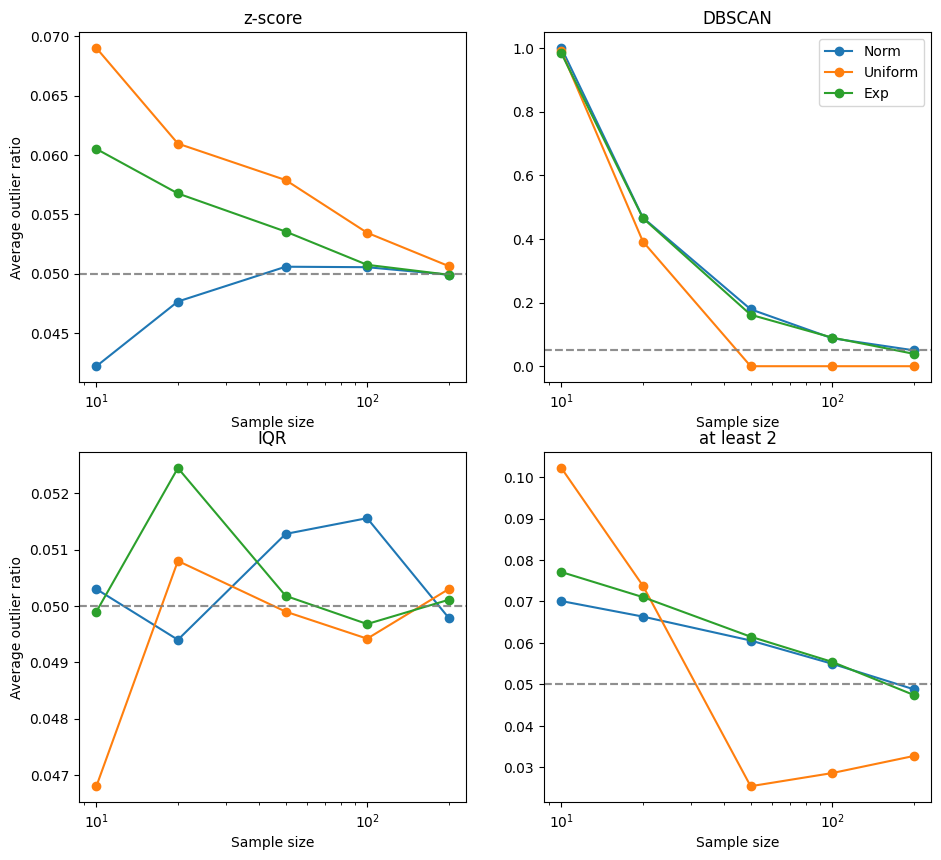

In [16]:
axis: list[list[plt.Axes]] = plt.subplots(2, 2, figsize=(11, 10))[1]

for method_id, method in enumerate(METHODS):
    ax = axis[method_id // 2][method_id % 2]
    ax.title.set_text(method)
    for distr_id, distr in enumerate(DISTROS):
        ax.plot(SAMPLE_SIZES, results[method][distr].values(), '-o', color='C'+str(distr_id), label=distr, alpha=1.)
        ax.axhline(y=FRR, color='gray', linestyle='--', alpha=0.5)
        ax.set_xlabel('Sample size')
        ax.set_xscale('log')
        # ax.set_ylim(FRR - 0.02, FRR + 0.02)
axis[0][1].legend()
axis[0][0].set_ylabel('Average outlier ratio')
axis[1][0].set_ylabel('Average outlier ratio')
plt.show()